# Afterpulse Detection (dead-time / internal reflections)
To figure out how to detect and remove afterpulses, and plot examples.
- use photon rate just around the lake surface elevation (depending on strong/weak beam??)
- then use peaks distances that are commonly found

### From the literature
afterpulses at: ∼0.45, ∼0.9, ∼2.3, and ∼4.2 m

The afterpulses captured from on-orbit measurements are caused by three different reasons: (1) the effects of the dead-time circuit (∼3 ns) due to PMT saturation; (2) the effects of optical reflections within the ATLAS receiver optical components; (3) PMT afterpulses. The echoes separated by ∼0.45 m are attributed to the effect of the dead-time circuit (∼3 ns) due to PMT saturation. The echoes at ∼2.3 and ∼4.2 m below the primary surface returns are caused by the optical reflections within the ATLAS receiver optical components, while the echoes from ∼10 to ∼45 m away from the primary surface signal are due to the PMT afterpulses with a longer time delay.

Lu, X., Hu, Y., Yang, Y., Vaughan, M., Palm, S., Trepte, C., ... & Baize, R. (2021). Enabling value added scientific applications of ICESat‐2 data with effective removal of afterpulses. Earth and Space Science, 8(6), e2021EA001729.

In [9]:
%matplotlib widget
import os
import pickle
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import Image, display
from cmcrameri import cm as cmc
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import find_peaks
plt.rcParams.update({'font.size': 8})

In [10]:
thresh_upper = 1.0
thresh_lower = -5.0
bin_h=0.01
smooth_h=0.1
extent_buffer = 21.0
smooth_pulse = 15 # makes it roughly the footprint size
strength = 'all'
saturation_threshold = 0.99

cols_pk = ['black','#CD104D', '#E14D2A', '#FD841F', '#8FE3CF', '#256D85']
lsty_pk = ['-', '-', '--', ':', '-', ':']
elev_pk_lake = [0.0, -0.55, -0.845, -1.36, -2.33, -4.17]
elev_pk_puls = [0.0, -0.55, -0.91, -1.465, -2.33, -4.17]
widths_pk = [0.225, 0.225, 0.225, 0.225, 0.3, 0.3] # 0.225 m on each side makes it 0.45 total, which is the dead-time for ATLAS
df_pks_info = pd.DataFrame({'h_lake': elev_pk_lake, 'h_pulse': elev_pk_puls, 'width': widths_pk, 'color': cols_pk, 'ls': lsty_pk})

def group_by_pulse(df_in, smoothing, beam_strength):
    thegroup = df_in.groupby('pulseid')
    df_grouped = thegroup[['xatc', 'h']].mean()
    norm_factor = 4 if beam_strength == 'weak' else 16
    df_grouped['ph_count'] = thegroup['h'].count() / norm_factor
    df_grouped['ph_count_smooth'] = np.array(df_grouped.ph_count.rolling(smoothing,center=True,min_periods=1).mean())
    return df_grouped

searchfor = '20210715'
searchdir = 'WAIS_region_comps/'
filelist = [searchdir+f for f in os.listdir(searchdir) \
            if os.path.isfile(os.path.join(searchdir, f)) & (searchfor in f) & ('.h5' in f)]# compare between afterpulses relative to lake surface / per-pulse saturated peak elevation

In [ ]:
searchfor = 'lake_'
searchdir = 'WAIS_region_comps/'
filelist = [searchdir+f for f in os.listdir(searchdir) \
            if os.path.isfile(os.path.join(searchdir, f)) & (searchfor in f) & ('.h5' in f)]

searchdir = '/GlacierLakeAnalysisICESat-2/WAIS_2018-22-meltregions'

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

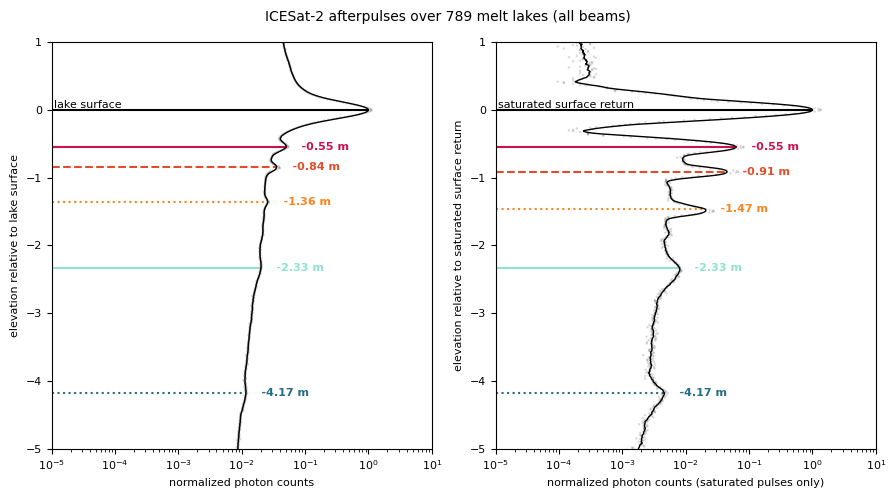

In [11]:
plt.close('all')
# lake_idxs = [3, 13, 23, 24, 28, 31, 35, 36, 37, 39, 43, 44, 45, 46, 48, 50, 51, 53, 54]
# lake_idxs = [50]

searchdir = ''
searchfor = 'lake_'
filelist = ['pickles/'+f for f in os.listdir('pickles') \
            if os.path.isfile(os.path.join('pickles', f)) & (searchfor in f)]

# for i in range(71):
# for i in lake_idxs:
#     fn = 'pickles/specular%02i.pkl' % i
#     with open(fn, 'rb') as f:
#         lk = pickle.load(f)

# filelist = filelist[:10]
df_list = []
perc_sat_list = []
n_lakes = 0
for filename in filelist:
    with open(filename, 'rb') as f:
        lk = pickle.load(f)
    
    surf_elev = lk['surface_elevation']
    df = lk['photon_data']
    beam_strength = lk['beam_strength']
    dfs = df[(df.h < (thresh_upper+surf_elev)) & (df.h > (thresh_lower+surf_elev))].copy()
    dfs['h'] = dfs.h - surf_elev
    dfs['pulseid'] = dfs.apply(lambda row: 1000*row.mframe+row.ph_id_pulse, axis=1)
    dfs['ph_index'] = dfs.index
    dfs = dfs.set_index('pulseid')
    pkinfo = df_pks_info.iloc[0]
    photon_df = dfs[(dfs.h >= (pkinfo.h_pulse - 0.175)) & (dfs.h < (pkinfo.h_pulse + 0.275))]
    df_pulses = group_by_pulse(photon_df,smooth_pulse,beam_strength)
    df_join = dfs.join(df_pulses, how='left', rsuffix='_pulse')
    df_join['pulseid'] = dfs.index
    df_join = df_join.set_index('ph_index')
    df_join['h_relative_to_saturated_peak'] = df_join.h - df_join.h_pulse
    df_join['is_saturated'] = df_join.ph_count_smooth >= saturation_threshold
    
    perc_sat_list.append(np.sum(df_join['is_saturated']) / len(df_join))
    
    if (strength not in ['weak','strong']) | (strength == beam_strength):
        df_list.append(df_join)
        n_lakes += 1
    
dfs = pd.concat(df_list)
df_saturated = dfs[dfs.ph_count_smooth > 0.99]
# df_saturated = dfs[dfs.ph_count > 0.99]

# histogram binning for afterpulse peaks vs. elevation
bins = np.arange(start=thresh_lower, stop=thresh_upper, step=bin_h)
mids = bins[:-1] + 0.5 * bin_h
smooth = int(smooth_h/bin_h)
if smooth %2 == 0: smooth += 1
def get_histograms(ph_heights):
    hist_h = np.histogram(ph_heights, bins=bins)
    hist_h_smooth = np.array(pd.Series(hist_h[0]).rolling(smooth,center=True,min_periods=1).mean())
    hist_h_plot = np.array(hist_h[0]) / hist_h_smooth.max()
    hist_h_smooth /= hist_h_smooth.max()
    return hist_h_plot, hist_h_smooth

hist_h_all, hist_h_smooth_all = get_histograms(dfs.h)
hist_h_sat, hist_h_smooth_sat = get_histograms(df_saturated.h)
hist_h_sat_adjusted, hist_h_smooth_sat_adjusted = get_histograms(df_saturated.h_relative_to_saturated_peak)

hist_h_issat = np.histogram(dfs.h_relative_to_saturated_peak[dfs.is_saturated], bins=bins)
hist_h_nosat = np.histogram(dfs.h[~dfs.is_saturated], bins=bins)
hist_h_issat = hist_h_issat[0] / np.sum(dfs.is_saturated)
hist_h_nosat = hist_h_nosat[0] / np.sum(~dfs.is_saturated)
hist_h_issat_smooth = np.array(pd.Series(hist_h_issat).rolling(smooth,center=True,min_periods=1).mean())
hist_h_nosat_smooth = np.array(pd.Series(hist_h_nosat).rolling(smooth,center=True,min_periods=1).mean())
normval = hist_h_issat_smooth.max()
hist_h_issat /= normval
hist_h_nosat /= normval
hist_h_issat_smooth /= normval
hist_h_nosat_smooth /= normval

fig, (ax,ax2) = plt.subplots(ncols=2, figsize=[9, 5], dpi=100)
ylms = (thresh_lower, thresh_upper)
xlim_ax2 = (1e-5,10)

# histogram showing peaks for specular returns
ax.scatter(hist_h_all, mids, s=3, color='black', lw=0.5, edgecolors='none', alpha=0.15)
ax.plot(hist_h_smooth_all, mids, 'k-', lw=1)
ax.set_xlabel('normalized photon counts')
ax.set_ylabel('elevation relative to lake surface')
ax.set_xlim(xlim_ax2)
ax.set_ylim(ylms)
ax.set_xscale('log')
for i in range(len(df_pks_info)):
    thispk = df_pks_info.iloc[i]
    thispeak_height = hist_h_smooth_all[np.argmin(np.abs(mids-thispk.h_lake))]
    ax.plot([xlim_ax2[0], thispeak_height], [thispk.h_lake]*2, color=thispk.color, ls=thispk.ls, zorder=-1000)
    if i == 0:
        ax.text(1.1*xlim_ax2[0], thispk.h_lake, 'lake surface', color=thispk.color, ha='left', va='bottom')
    else:
        ax.text(thispeak_height, thispk.h_lake, '    %.2f m' % thispk.h_lake, color=thispk.color, weight='bold', va='center')


ax2.scatter(hist_h_sat_adjusted, mids, s=3, color='black', lw=0.5, edgecolors='none', alpha=0.15)
ax2.plot(hist_h_smooth_sat_adjusted, mids, 'k-', lw=1)
# ax2.plot(hist_h_issat_smooth, mids, 'r-', lw=2)
# ax2.plot(hist_h_nosat_smooth, mids, 'k-', lw=1, zorder=-100)
# ax2.scatter(hist_h_issat, mids, s=3, color='red', lw=0.5, edgecolors='none', alpha=0.15, zorder=-200)
# ax2.scatter(hist_h_nosat, mids, s=3, color='black', lw=0.5, edgecolors='none', alpha=0.15, zorder=-300)
ax2.set_xlabel('normalized photon counts (saturated pulses only)')
ax2.set_ylabel('elevation relative to saturated surface return')
ax2.set_xlim(xlim_ax2)
ax2.set_ylim(ylms)
ax2.set_xscale('log')
for i in range(len(df_pks_info)):
    thispk = df_pks_info.iloc[i]
    thispeak_height = hist_h_smooth_sat_adjusted[np.argmin(np.abs(mids-thispk.h_pulse))]
    ax2.plot([xlim_ax2[0], thispeak_height], [thispk.h_pulse]*2, color=thispk.color, ls=thispk.ls, zorder=-1000)
    if i == 0:
        ax2.text(1.1*xlim_ax2[0], thispk.h_pulse, 'saturated surface return', color=thispk.color, ha='left', va='bottom')
    else:
        ax2.text(thispeak_height, thispk.h_pulse, '    %.2f m' % thispk.h_pulse, color=thispk.color, weight='bold', va='center')
        
fig.suptitle('ICESat-2 afterpulses over %i melt lakes (%s beams)' % (n_lakes, strength), y=0.98, fontsize=10)
fig.tight_layout()

figname = 'figs_afterpulses/ICESat-2-afterpulses-melt-lakes-%s-beams.jpg' % strength
fig.savefig(figname, dpi=300, bbox_inches='tight', pad_inches=0)
display(fig)

# Plot comparison between weak and strong beams

In [12]:
plt.close('all')

for strength in ['all', 'weak', 'strong']:
    df_list = []
    n_lakes = 0
    
    for filename in filelist:
        with open(filename, 'rb') as f:
            lk = pickle.load(f)

        surf_elev = lk['surface_elevation']
        df = lk['photon_data']
        beam_strength = lk['beam_strength']
        dfs = df[(df.h < (thresh_upper+surf_elev)) & (df.h > (thresh_lower+surf_elev))].copy()
        dfs['h'] = dfs.h - surf_elev
        dfs['pulseid'] = dfs.apply(lambda row: 1000*row.mframe+row.ph_id_pulse, axis=1)
        dfs = dfs.set_index('pulseid')
        df_surf_photons = dfs[(dfs.h >= -0.175) & (dfs.h < 0.275)].copy()
        df_pulses = group_by_pulse(df_surf_photons, smooth_pulse, beam_strength)
        df_join = dfs.join(df_pulses, how='left', rsuffix='_pulse')
        df_join['h_relative_to_saturated_peak'] = df_join.h - df_join.h_pulse
        if (strength not in ['weak','strong']) | (strength == beam_strength):
            n_lakes += 1
            df_list.append(df_join)

    dfs = pd.concat(df_list)
    df_saturated = dfs[dfs.ph_count_smooth > 0.99]
    # df_saturated = dfs[dfs.ph_count > 0.99]

    # histogram binning for afterpulse peaks vs. elevation
    bins = np.arange(start=thresh_lower, stop=thresh_upper, step=bin_h)
    mids = bins[:-1] + 0.5 * bin_h
    smooth = int(smooth_h/bin_h)
    if smooth %2 == 0: smooth += 1
    def get_histograms(ph_heights):
        hist_h = np.histogram(ph_heights, bins=bins)
        hist_h_smooth = np.array(pd.Series(hist_h[0]).rolling(smooth,center=True,min_periods=1).mean())
        hist_h_plot = np.array(hist_h[0]) / hist_h_smooth.max()
        hist_h_smooth /= hist_h_smooth.max()
        return hist_h_plot, hist_h_smooth

    hist_h_all, hist_h_smooth_all = get_histograms(dfs.h)
    hist_h_sat, hist_h_smooth_sat = get_histograms(df_saturated.h)
    hist_h_sat_adjusted, hist_h_smooth_sat_adjusted = get_histograms(df_saturated.h_relative_to_saturated_peak)

    fig, ax2 = plt.subplots(ncols=1, figsize=[5, 5], dpi=100)
    ylms = (thresh_lower, thresh_upper)
    xlim_ax2 = (1e-5,10)

    # histogram showing peaks for specular returns
    ax2.scatter(hist_h_sat_adjusted, mids, s=3, color='black', lw=0.5, edgecolors='none', alpha=0.15)
    ax2.plot(hist_h_smooth_sat_adjusted, mids, 'k-', lw=1)
    ax2.set_xlabel('normalized photon counts (saturated pulses only)')
    ax2.set_ylabel('elevation relative to saturated surface return')
    ax2.set_xlim(xlim_ax2)
    ax2.set_ylim(ylms)
    ax2.set_xscale('log')
    for i in range(len(df_pks_info)):
        thispk = df_pks_info.iloc[i]
        thispeak_height = hist_h_smooth_sat_adjusted[np.argmin(np.abs(mids-thispk.h_pulse))]
        ax2.plot([xlim_ax2[0], thispeak_height], [thispk.h_pulse]*2, color=thispk.color, ls=thispk.ls, zorder=-1000)
        if i == 0:
            ax2.text(1.1*xlim_ax2[0], thispk.h_pulse, 'saturated surface return', color=thispk.color, ha='left', va='bottom')
        else:
            ax2.text(thispeak_height, thispk.h_pulse, '    %.2f m' % thispk.h_pulse, color=thispk.color, weight='bold', va='center')

    ax2.text(0.7, 0.95, '%s beams' % strength, ha='center', va='center', fontsize=10, weight='bold', color='red', transform=ax2.transAxes)
    txt = 'ICESat-2 afterpulses over %i melt lakes\n' % n_lakes
    ax2.set_title(txt, fontsize=10)
    fig.tight_layout()

    figname = 'figs_afterpulses/ICESat2_meltlake-afterpulses-%s-beams.jpg' % strength
    fig.savefig(figname, dpi=300, bbox_inches='tight', pad_inches=0)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Example of second return removal

In [ ]:
%matplotlib widget
import os
import pickle
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import Image, display
from cmcrameri import cm as cmc
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import find_peaks
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gsp
plt.rcParams.update({'font.size': 5})

def group_by_pulse(df_in, smoothing, beam_strength):
    thegroup = df_in.groupby('pulseid')
    df_grouped = thegroup[['xatc', 'h']].mean()
    norm_factor = 4 if beam_strength == 'weak' else 16
    df_grouped['ph_count'] = thegroup['h'].count() / norm_factor
    df_grouped['ph_count_smooth'] = np.array(df_grouped.ph_count.rolling(smoothing,center=True,min_periods=1).mean())
    return df_grouped

def get_histograms(ph_heights, bins, smooth):
    hist_h = np.histogram(ph_heights, bins=bins)
    hist_h_smooth = np.array(pd.Series(hist_h[0]).rolling(smooth,center=True,min_periods=1).mean())
    hist_h_plot = np.array(hist_h[0]) / hist_h_smooth.max()
    hist_h_smooth /= hist_h_smooth.max()
    return hist_h_plot, hist_h_smooth

def plot_counts(df_in, df_pks_info, thisax, alph):
    thisax.scatter(df_in.xatc, df_in.ph_count, s=3, color=df_pks_info.iloc[i].color, edgecolors='none', alpha=alph)
    thisax.plot(df_in.xatc, df_in.ph_count_smooth, color=df_pks_info.iloc[i].color, ls=df_pks_info.iloc[i].ls, lw=1)
    
def hex2rgb(hex_str):
    return list(np.array([int(hex_str.lstrip('#')[i:i+2], 16) for i in (0, 2, 4)],dtype=float)/255)

thresh_upper = 1.0
thresh_lower = -5.0
bin_h = 0.01
smooth_h = 0.1
extent_buffer = 20.0
smooth_pulse = 1 # makes it roughly the footprint size
smooth_pulse_plot = 20 # to get an idea from the plot
saturation_threshold = 0.97
removal_width_adjust = 0.5
surf_saturation_detection_limits = [-0.3,0.5]
surf_saturation_detection_step = 0.025


cols_pk = ['#000000','#CD104D', '#E14D2A', '#FD841F', '#8FE3CF', '#256D85']
desc_pk = ['lake surface', 'dead time (1st)', 'dead time (2nd)', 'dead time (3rd)',
           'internal reflection (1st)', 'internal reflection (2nd)']
lsty_pk = ['-', '-', '--', ':', '-', ':']
elev_pk_lake = [0.0, -0.55, -0.845, -1.36, -2.4, -4.2]
elev_pk_puls = [0.0, -0.55, -0.91, -1.465, -2.4, -4.2]
widths_pk = [0.225, 0.225, 0.225, 0.225, 0.3, 0.3] # 0.225 m on each side makes it 0.45 total, which is the dead-time for ATLAS
df_pks_info = pd.DataFrame({'h_lake': elev_pk_lake, 'h_pulse': elev_pk_puls, 'width': widths_pk, 
                            'description': desc_pk, 'color': cols_pk, 'ls': lsty_pk})

In [ ]:
idxs

In [ ]:
inv_perc_sat = 1-np.array(perc_sat_list)
idxs = np.argsort(inv_perc_sat)
sortedlist = np.sort(inv_perc_sat)
fn_sorted = [filelist[idx] for idx in idxs]
for i in range(3):
    print ('%.3f, \'%s\'' % (1-sortedlist[i], fn_sorted[i]))

In [ ]:
plt.close('all')

searchfor = 'specular_test0001_'

filelist = ['pickles/'+f for f in os.listdir('pickles') \
            if os.path.isfile(os.path.join('pickles', f)) & (searchfor in f)]

filelist = ['pickles/testdata_01207_nivlisen_test_2020-01-16_0312_lake0002.pkl',
            'pickles/testdata_07013_jakobshavn_test_2021-07-15_0338_lake0042.pkl',
            'pickles/testdata_07485_amery_test_2019-01-02_0081_lake0031.pkl',
            'pickles/testdata_04845_jakobshavn_test_2021-07-15_0338_lake0043.pkl',
            'pickles/testdata_03749_79N_test_2019-08-22_0848_lake0002.pkl',
            'pickles/testdata_06401_jakobshavn_test_2021-07-15_0338_lake0045.pkl',
            'pickles/testdata_07215_amery_test_2019-01-02_0081_lake0009.pkl',
            'pickles/testdata_09130_jakobshavn_test_2021-08-09_0719_lake0056.pkl',
            'pickles/testdata_09318_GrIS-NE-test_2021-08-22_0909_lake0005.pkl',
            'pickles/testdata_08171_jakobshavn_test_2021-07-15_0338_lake0016.pkl',
            'pickles/testdata_09748_GrIS-NE-test_2021-08-22_0909_lake0001.pkl',
            'pickles/testdata_09203_GrIS-NE-test_2021-08-22_0909_lake0005.pkl',
            'pickles/testdata_08324_jakobshavn_test_2021-08-02_0605_lake0032.pkl',
            'pickles/testdata_09578_amery_test_2019-01-02_0081_lake0048.pkl']

for filename in filelist:

    with open(filename, 'rb') as f:
        lk = pickle.load(f)

    surf_elev = lk['surface_elevation']
    df = lk['photon_data']
    beam_strength = lk['beam_strength']

    df['is_afterpulse'] = False
    selector_afterpulse_search = (df.h < (thresh_upper+surf_elev)) & (df.h > (thresh_lower+surf_elev))
    dfs = df[selector_afterpulse_search].copy()
    dfs['h'] = dfs.h - surf_elev
    dfs['pulseid'] = dfs.apply(lambda row: 1000*row.mframe+row.ph_id_pulse, axis=1)
    dfs['ph_index'] = dfs.index
    dfs = dfs.set_index('pulseid')
    pkinfo = df_pks_info.iloc[0]
    photon_df = dfs[(dfs.h >= (pkinfo.h_pulse - 0.2)) & (dfs.h < (pkinfo.h_pulse + pkinfo.width))]
    df_pulses = group_by_pulse(photon_df,smooth_pulse,beam_strength)
    df_join = dfs.join(df_pulses, how='left', rsuffix='_pulse')
    df_join['pulseid'] = dfs.index
    df_join = df_join.set_index('ph_index')
    df_join['h_relative_to_saturated_peak'] = df_join.h - df_join.h_pulse
    df_join['is_saturated'] = df_join.ph_count_smooth >= saturation_threshold 

    # histogram binning for plotting afterpulse peaks vs. elevation
    bins = np.arange(start=thresh_lower, stop=thresh_upper, step=bin_h)
    mids = bins[:-1] + 0.5 * bin_h
    smooth = int(smooth_h/bin_h)
    if smooth %2 == 0: smooth += 1
    hist_h, hist_h_smooth = get_histograms(df_join.h_relative_to_saturated_peak, bins, smooth)

    # get saturation ratio for each possible afterpulse
    pulse_dfs = []
    for i in range(len(df_pks_info)):
        pkinfo = df_pks_info.iloc[i]
        photon_df = df_join[(df_join.h >= (pkinfo.h_pulse - pkinfo.width)) & (df_join.h < (pkinfo.h_pulse + pkinfo.width))]
        pulse_dfs.append(group_by_pulse(photon_df, smooth_pulse_plot, beam_strength))

    # indicate possible afterpulses
    for i in range(1, len(df_pks_info)):
        pkinfo = df_pks_info.iloc[i]
        is_in_afterpulse_range = (df_join.h >= (pkinfo.h_lake - pkinfo.width)) & (df_join.h < (pkinfo.h_lake + pkinfo.width))
        is_afterpulse = is_in_afterpulse_range & df_join.is_saturated
        df_join.loc[is_afterpulse, 'is_afterpulse'] = True

    df.loc[selector_afterpulse_search, 'is_afterpulse'] = df_join.is_afterpulse

    # get saturated segments that are continuous for longer than x meters, for plotting
    current_list, saturat_segs, i = [], [], 0
    min_length_saturated_plot = 15.0 # roughly the footprint size
    while i < len(df_join):
        if df_join.is_saturated.iloc[i]:
            current_list.append(i)
        elif len(current_list) > 1:
            saturat_segs.append([df_join.xatc.iloc[current_list[0]], df_join.xatc.iloc[current_list[-1]]])
            current_list = []
        i += 1 
    saturat_segs_xatc = [item for item in saturat_segs if np.abs(item[-1] - item[0]) > min_length_saturated_plot]

    df_plot_afterpulses = df[df.is_afterpulse]
    df_plot_no_afterpulses = df[~df.is_afterpulse]

    #__________________________________________________________________
    # make the figure
    #fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=[9, 5], dpi=100)
    fig = plt.figure(figsize=[9, 5], dpi=100)
    gs = fig.add_gridspec(4, 4)
    ax1 = fig.add_subplot(gs[ :2,  :2])
    ax2 = fig.add_subplot(gs[ :2, 2:4])
    ax3 = fig.add_subplot(gs[2:4,  :2])
    ax4 = fig.add_subplot(gs[2:4, 2:3])
    ax5 = fig.add_subplot(gs[2:4, 3:4])

    if len(lk['surface_extent_detection'])>0:
        xlms = (lk['surface_extent_detection'][0][0]-extent_buffer, lk['surface_extent_detection'][-1][-1]+extent_buffer)
    else:
        xlms = (df_join.xatc.min(), df_join.xatc.max())
    xlim_ax2 = (5e-5,2)
    ylms = (thresh_lower, thresh_upper)
    lbpd = 0 # axis label padding
    lbsz = 7 # axis label font size

    #------------------------------------------------------------------
    # ax1: selected photons
    ax = ax1
    pscatt = ax.scatter(dfs.xatc, dfs.h, s=1, c='k', alpha=1, edgecolors='none',label='ATL03 data')
    ax.scatter(df_plot_afterpulses.xatc, df_plot_afterpulses.h-surf_elev, s=1.5, c='k', edgecolors='none')
    ax.scatter(df_plot_afterpulses.xatc, df_plot_afterpulses.h-surf_elev, s=1, c='r', edgecolors='none')

    # title and labels
    ax.set_axisbelow(True)
    ax.grid(which='major', axis='both', color='gray', lw=0.5, alpha=0.3)
    ax.set_xlim(xlms)
    ax.set_ylim(ylms)
    bbox = {'fc':(1,1,1,0.75), 'ec':(1,1,1,0), 'pad':1}
    ax.text(0.5, 0.95, 'ATL03 photon data', va='center', ha='center', fontsize=8, weight='bold', bbox=bbox, transform=ax.transAxes)
    ax.set_xlabel('along-track distance [m]', fontsize=lbsz, labelpad=lbpd)
    ax.set_ylabel('elevation realtive to lake surface [m]', fontsize=lbsz, labelpad=lbpd)

    #------------------------------------------------------------------
    # ax2: histogram showing peaks for specular returns
    ax = ax2
    ax.scatter(hist_h, mids, s=3, color='black', lw=0.5, edgecolors='none', alpha=0.15)
    ax.plot(hist_h_smooth, mids, 'k-', lw=1)
    ax.set_xlim(xlim_ax2)
    ax.set_ylim(ylms)
    ax.set_xscale('log')
    ax.grid(which='major', axis='y', color='gray', lw=0.5, alpha=0.3)
    for i in range(len(df_pks_info)):
        thispk = df_pks_info.iloc[i]
        thispeak_height = hist_h_smooth[np.argmin(np.abs(mids-thispk.h_pulse))]
        ax.plot([xlim_ax2[0], thispeak_height], [thispk.h_pulse]*2, color=thispk.color, ls=thispk.ls, zorder=-1000, lw=0.5)
        if i == 0:
            ax.text(1.1*xlim_ax2[0], thispk.h_pulse, 'saturated surface return', color=thispk.color, 
                    ha='left', va='bottom', fontsize=7)
        else:
            ax.text(thispeak_height, thispk.h_pulse, '    %.2f m' % thispk.h_pulse, color=thispk.color, 
                    weight='bold', va='center', fontsize=7)
    ax.set_xlabel('normalized photon counts (saturated pulses only)', fontsize=lbsz, labelpad=lbpd)
    ax.set_ylabel('elevation relative to saturated\npulse surface peak [m]', fontsize=lbsz, labelpad=lbpd)

    #-------------------------------------------------
    # plot photon counts per shot
    alph = 0.1
    ax = ax3

    for i,this_peak_pulse_df in enumerate(pulse_dfs):
        plot_counts(this_peak_pulse_df, df_pks_info, ax, alph)

    ax.set_xlim(xlms)
    ax.set_yscale('log')
    ax.grid(which='major', axis='x', color='gray', lw=0.5, alpha=0.3)
    ax.set_yticks([])
    if beam_strength == 'strong':
        yts = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        ax.set_ylim((1/16,1.05))
    if beam_strength == 'weak':
        ax.set_ylim((1/4,1.05))
        yts = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    ytl = ['%.1f'%yt for yt in yts]
    ax.set_yticks(yts)
    ax.set_yticklabels(ytl)
    ax.set_xlabel('along-track distance [m]', fontsize=lbsz, labelpad=lbpd)
    ax.set_ylabel('% saturated per pulse', fontsize=lbsz, labelpad=lbpd)

    #-------------------------------------------------
    # the full lake, for reference
    rng = np.abs(surf_elev-np.min(lk['detection_2nd_returns']['h']))
    yls = (surf_elev-1.1*rng, surf_elev+0.3*rng)

    # all the data 
    ax = ax4
    ax.scatter(df.xatc, df.h, c='k', s=1, alpha=1, edgecolors='none')
    ax.set_xlim((df.xatc.min(),df.xatc.max()))
    ax.set_ylim(yls)
    bbox = {'fc':(1,1,1,0.75), 'ec':(1,1,1,0), 'pad':1}
    ax.text(0.5, 0.95, 'all photons', va='center', ha='center', fontsize=8, weight='bold', bbox=bbox, transform=ax.transAxes)
    ax.set_xlabel('along-track distance [m]', fontsize=lbsz-1, labelpad=lbpd)
    ax.set_ylabel('elevation above geoid [m]', fontsize=lbsz, labelpad=lbpd)

    # now with afterpulses removed
    ax = ax5
    ax.scatter(df_plot_no_afterpulses.xatc, df_plot_no_afterpulses.h, c='k', s=1, alpha=1, edgecolors='none')
    ax.set_xlim((df.xatc.min(),df.xatc.max()))
    ax.set_ylim(yls)
    ax.set_yticks([])
    bbox = {'fc':(1,1,1,0.75), 'ec':(1,1,1,0), 'pad':1}
    ax.text(0.5, 0.95, 'afterpulses removed', va='center', ha='center', fontsize=8, weight='bold', bbox=bbox, transform=ax.transAxes)
    ax.set_xlabel('along-track distance [m]', fontsize=lbsz-1, labelpad=lbpd)

    #_________________________________________________
    # highlight saturated areas
    alph = 0.3
    sat_color = [1, 1, 0]
    for seg_xatc in saturat_segs_xatc:
        # highlight saturation on ax3
        yls = ax3.get_ylim()
        xy, width, height = (seg_xatc[0], yls[0]), np.abs(seg_xatc[-1]-seg_xatc[0]), yls[-1]-yls[0]
        rct = Rectangle(xy, width, height, ec=(1,1,1,0), fc=sat_color+[alph], zorder=-1000)
        ax3.add_patch(rct)
        # highlight saturation on ax1, where they overlap
        yls = ax1.get_ylim()
        xy, width, height = (seg_xatc[0], yls[0]), np.abs(seg_xatc[-1]-seg_xatc[0]), yls[-1]-yls[0]
        rct = Rectangle(xy, width, height, ec=(1,1,1,0), fc=sat_color+[alph], zorder=-1000)
        ax1.add_patch(rct)

    # highlight peak ranges 
    afterpulse_hdls = []
    for i in range(1,len(df_pks_info)):
        info = df_pks_info.iloc[i]
        # highlight ranges on ax2
        lower, upper = info.h_pulse-info.width*removal_width_adjust, info.h_pulse+info.width*removal_width_adjust
        selector = (mids > lower) & (mids < upper)
        ys_fill, x1_fill = mids[selector], hist_h_smooth[selector]
        x2_fill = [xlim_ax2[0]]*len(ys_fill)
        thiscolor = hex2rgb(info.color) + [alph]
        hdl = ax2.fill_betweenx(ys_fill, x1_fill, x2_fill, ec=(1,1,1,0), fc=thiscolor, zorder=-10000, label=info.description)
        afterpulse_hdls.append(hdl)
        # highlight ranges on ax1, where they overlap
        xy, width, height = (xlms[0],info.h_lake-info.width*removal_width_adjust), xlms[1]-xlms[0], info.width*removal_width_adjust*2
        thiscolor = hex2rgb(info.color) + [alph]
        rct = Rectangle(xy, width, height, ec=(1,1,1,0), fc=thiscolor, zorder=-1000)
        ax1.add_patch(rct)

    ax2.legend(handles=afterpulse_hdls, loc='lower right')

    #_________________________________________________
    # final figure stuff
    txt  = 'REMOVAL OF ICESat-2 SPECULAR RETURN AFTERPULSES OVER A MELT LAKE\n'
    txt += 'location: %s, %s (area: %s) | ' % (lk['lat_str'], lk['lon_str'], lk['polygon_name'])
    txt += 'time: %s UTC | surface elevation: %.2f m\n' % (lk['date_time'], lk['surface_elevation'])
    txt += 'RGT %s %s cycle %i | ' % (lk['rgt'], lk['gtx'].upper(), lk['cycle_number'])
    txt += 'beam %i (%s, %s spacecraft orientation) | ' % (lk['beam_number'], lk['beam_strength'], lk['sc_orient'])
    txt += 'granule ID: %s' % lk['granule_id']
    fig.suptitle(txt, y=0.98, fontsize=9)
    fig.tight_layout()

    figname = 'figs_afterpulses/afterpulse_removal_%s.jpg' % filename[filename.rfind('/')+1:].replace('.pkl', '')
    fig.savefig(figname, dpi=300, bbox_inches='tight', pad_inches=0)

# testing

In [ ]:
%matplotlib widget
import pickle
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import Image, display
from cmcrameri import cm as cmc
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import find_peaks
plt.rcParams.update({'font.size': 8})

def group_by_pulse(df_in, smoothing, beam_strength):
    thegroup = df_in.groupby('pulseid')
    df_grouped = thegroup[['xatc', 'h']].mean()
    norm_factor = 4 if beam_strength == 'weak' else 16
    df_grouped['ph_count'] = thegroup['h'].count() / norm_factor
    df_grouped['ph_count_smooth'] = np.array(df_grouped.ph_count.rolling(smoothing,center=True,min_periods=1).mean())
    return df_grouped

def get_histograms(ph_heights, bins, smooth):
    hist_h = np.histogram(ph_heights, bins=bins)
    hist_h_smooth = np.array(pd.Series(hist_h[0]).rolling(smooth,center=True,min_periods=1).mean())
    hist_h_plot = np.array(hist_h[0]) / hist_h_smooth.max()
    hist_h_smooth /= hist_h_smooth.max()
    return hist_h_plot, hist_h_smooth

def plot_counts(df_in, df_pks_info, thisax, alph):
    thisax.scatter(df_in.xatc, df_in.ph_count, s=3, color=df_pks_info.iloc[i].color, edgecolors='none', alpha=alph)
    thisax.plot(df_in.xatc, df_in.ph_count_smooth, color=df_pks_info.iloc[i].color, ls=df_pks_info.iloc[i].ls)
    
thresh_upper = 1.0
thresh_lower = -5.0
bin_h = 0.01
smooth_h = 0.1
extent_buffer = 20.0
smooth_pulse = 15 # makes it roughly the footprint size
saturation_threshold = 0.95

cols_pk = ['black','#CD104D', '#E14D2A', '#FD841F', '#8FE3CF', '#256D85']
lsty_pk = ['-', '-', '--', ':', '-', ':']
elev_pk_lake = [0.0, -0.55, -0.845, -1.36, -2.4, -4.2]
elev_pk_puls = [0.0, -0.55, -0.91, -1.465, -2.4, -4.2]
widths_pk = [0.225, 0.225, 0.225, 0.225, 0.3, 0.3] # 0.225 m on each side makes it 0.45 total, which is the dead-time for ATLAS
df_pks_info = pd.DataFrame({'h_lake': elev_pk_lake, 'h_pulse': elev_pk_puls, 'width': widths_pk, 'color': cols_pk, 'ls': lsty_pk})

plt.close('all')
i = 50

fn = 'pickles/specular%02i.pkl' % i
with open(fn, 'rb') as f:
    lk = pickle.load(f)

surf_elev = lk['surface_elevation']
df = lk['photon_data']
beam_strength = lk['beam_strength']
dfs = df[(df.h < (thresh_upper+surf_elev)) & (df.h > (thresh_lower+surf_elev))].copy()
dfs['h'] = dfs.h - surf_elev
dfs['pulseid'] = dfs.apply(lambda row: 1000*row.mframe+row.ph_id_pulse, axis=1)
dfs['ph_index'] = dfs.index
dfs = dfs.set_index('pulseid')
pkinfo = df_pks_info.iloc[0]
photon_df = dfs[(dfs.h >= (pkinfo.h_pulse - pkinfo.width)) & (dfs.h < (pkinfo.h_pulse + pkinfo.width))]
df_pulses = group_by_pulse(photon_df,smooth_pulse,beam_strength)
df_join = dfs.join(df_pulses, how='left', rsuffix='_pulse')
df_join['pulseid'] = dfs.index
df_join = df_join.set_index('ph_index')
df_join['h_relative_to_saturated_peak'] = df_join.h - df_join.h_pulse
df_join['is_saturated'] = df_join.ph_count_smooth >= saturation_threshold 

# histogram binning for plotting afterpulse peaks vs. elevation
bins = np.arange(start=thresh_lower, stop=thresh_upper, step=bin_h)
mids = bins[:-1] + 0.5 * bin_h
smooth = int(smooth_h/bin_h)
if smooth %2 == 0: smooth += 1
# hist_h, hist_h_smooth = get_histograms(df_join.h_relative_to_saturated_peak[df_join.is_saturated], bins, smooth)

hist_h_issat = np.histogram(df_join.h_relative_to_saturated_peak[df_join.is_saturated], bins=bins)
hist_h_nosat = np.histogram(df_join.h[~df_join.is_saturated], bins=bins)
hist_h_issat = hist_h_issat[0] / np.sum(df_join.is_saturated)
hist_h_nosat = hist_h_nosat[0] / np.sum(~df_join.is_saturated)
hist_h_issat_smooth = np.array(pd.Series(hist_h_issat).rolling(smooth,center=True,min_periods=1).mean())
hist_h_nosat_smooth = np.array(pd.Series(hist_h_nosat).rolling(smooth,center=True,min_periods=1).mean())
normval = hist_h_issat_smooth.max()
hist_h_issat /= normval
hist_h_nosat /= normval
hist_h_issat_smooth /= normval
hist_h_nosat_smooth /= normval

# get saturation ratio for each possible afterpulse
pulse_dfs = []
for i in range(len(df_pks_info)):
    pkinfo = df_pks_info.iloc[i]
    photon_df = df_join[(df_join.h >= (pkinfo.h_pulse - pkinfo.width)) & (df_join.h < (pkinfo.h_pulse + pkinfo.width))]
    pulse_dfs.append(group_by_pulse(photon_df,smooth_pulse,beam_strength))

#__________________________________________________________________
# make the figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[5, 5], dpi=100)
xlms = (df_join.xatc.min(), df_join.xatc.max())
xlim_ax2 = (5e-5,2)
ylms = (thresh_lower, thresh_upper)

#------------------------------------------------------------------
# ax: histogram showing peaks for specular returns
ax.plot(hist_h_issat_smooth, mids, 'r-', lw=2)
ax.plot(hist_h_nosat_smooth, mids, 'k-', lw=1, zorder=-100)
ax.scatter(hist_h_issat, mids, s=3, color='red', lw=0.5, edgecolors='none', alpha=0.15, zorder=-200)
ax.scatter(hist_h_nosat, mids, s=3, color='black', lw=0.5, edgecolors='none', alpha=0.15, zorder=-300)
ax.set_xlabel('normalized photon counts (saturated pulses only)')
ax.set_ylabel('elevation relative to saturated\npulse surface peak [m]')
ax.set_xlim(xlim_ax2)
ax.set_ylim(ylms)
ax.set_xscale('log')
for i in range(len(df_pks_info)):
    thispk = df_pks_info.iloc[i]
    thispeak_height = hist_h_smooth[np.argmin(np.abs(mids-thispk.h_pulse))]
    ax.plot([xlim_ax2[0], thispeak_height], [thispk.h_pulse]*2, color=thispk.color, ls=thispk.ls, zorder=-1000)
    if i == 0:
        ax.text(1.1*xlim_ax2[0], thispk.h_pulse, 'saturated surface return', color=thispk.color, ha='left', va='bottom')
    else:
        ax.text(thispeak_height, thispk.h_pulse, '    %.2f m' % thispk.h_pulse, color=thispk.color, weight='bold', va='center')

fig.suptitle('example of specular return afterpulses over a melt lake in ICESat-2 data', y=0.98, fontsize=10)
fig.tight_layout()

# figname = 'figs_afterpulses/afterpulse_my-example_lake.jpg'

In [ ]:
df_join.h[df_join.is_saturated]

In [ ]:
pulse_group = dfs.groupby('pulseid')
df_pulse = pulse_group[['xatc', 'lat', 'lon']].mean()
df_pulse['ph_count'] = pulse_group['h'].count()
df_pulse['ph_count_smooth'] = np.array(df_pulse.ph_count.rolling(smooth_pulse,center=True,min_periods=1).mean())

pulse_group_top = df_top.groupby('pulseid')
df_pulse_top = pulse_group_top[['xatc', 'lat', 'lon']].mean()
df_pulse_top['ph_count'] = pulse_group_top['h'].count()
df_pulse_top['ph_count_smooth'] = np.array(df_pulse_top.ph_count.rolling(smooth_pulse,center=True,min_periods=1).mean())


In [ ]:
pulse_dfs[0]

In [ ]:
df_pulse

In [ ]:
mframe_group = df.groupby('mframe')
    df_mframe = mframe_group[['lat','lon', 'xatc', 'dt']].mean()
    df_mframe.drop(df_mframe.head(1).index,inplace=True)
    df_mframe.drop(df_mframe.tail(1).index,inplace=True)
    df_mframe['time'] = df_mframe['dt'].map(convert_time_to_string)
    df_mframe['xatc_min'] = mframe_group['xatc'].min()
    df_mframe['xatc_max'] = mframe_group['xatc'].max()
    df_mframe['n_phot'] = mframe_group['h'].count()

In [ ]:
# pulse_dfs[0].loc[pulse_dfs[0].iloc[:5].index]
df_pulses = pulse_dfs[0]
idx1 = df_pulses[df_pulses.ph_count > 0.99].index
idx2 = df_pulses[df_pulses.ph_count > 0.99].index
idx1.append(idx2)

In [ ]:
lk['photon_data']

In [ ]:
ax.get_xlim()